# 08 EMT

## Notebook setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import warnings, scipy.sparse as sp, matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc_context
from collections import Counter
import matplotlib.font_manager
import openpyxl
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
#import magic
#import seaborn as sns
import palantir
import loompy
import feather
import re
#from scipy.sparse import csgraph

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rc('font', size=14)
import matplotlib.lines as lines

pd.set_option('display.max_rows', 200)

sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.2 scipy==1.5.3 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
user_defined_palette =  [ '#F6222E', '#FEAF16','#3283FE','#BDCDFF', '#3B00FB', '#F8A19F', '#1CFFCE',  '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F','#B5EFB5', '#0e452b', '#AA0DFE']

In [3]:
user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])

In [4]:
%matplotlib inline 

## Load Fig 1a data

In [5]:
path_to_h5ad = '../output/anndata_io/Fig1af.h5ad'

In [7]:
adata_d0 = sc.read_h5ad(path_to_h5ad)
adata_d0.uns['log1p']["base"] = None

In [8]:
adata_d0.shape

(22932, 27657)

### EMT signature

In [9]:
adata_d0.obs['stage_and_subset'] = ''
adata_d0.obs['stage_and_subset'] = adata_d0.obs[['stage', 'cell_type_subset']].agg('_'.join, axis=1)

In [10]:
TEC_d0_emt = adata_d0[((adata_d0.obs['cell_type_subset']=='10:aaTEC1') |
                        (adata_d0.obs['cell_type_subset']=='11:aaTEC2') |
                        (adata_d0.obs['cell_type_subset']=='12:cTEC') |
                        (adata_d0.obs['cell_type_subset']=='12:early Pr') |
                        (adata_d0.obs['cell_type_subset']=='13:mTEC1') |
                        (adata_d0.obs['cell_type_subset']=='5:medFB')) & (adata_d0.obs['stage']=='18mo')]

In [11]:
sc.pp.filter_genes(TEC_d0_emt, min_cells=1)

filtered out 4762 genes that are detected in less than 1 cells


In [12]:
import magic

In [13]:
emt_genes = pd.read_excel('../data/public/mmc2.xlsx')

In [14]:
emt_genes_common = TEC_d0_emt.var.index & emt_genes.gene.values

In [15]:
magic_op = magic.MAGIC()

In [16]:
magic_op.set_params(knn=5, t=4)

MAGIC(knn_max=15, t=4)

In [17]:
adata_d0_emt_magic = magic_op.fit_transform(TEC_d0_emt, genes=emt_genes)

Calculating MAGIC...
  Running MAGIC on 5608 cells and 22895 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.10 seconds.
    Calculating affinities...
    Calculated affinities in 2.14 seconds.
  Calculated graph and diffusion operator in 7.43 seconds.
  Running MAGIC with `solver='exact'` on 8725-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 14.53 seconds.
Calculated MAGIC in 78.35 seconds.


In [18]:
adata_d0_emt_magic.obs['cdh1_time'] = -pd.DataFrame(adata_d0_emt_magic.X, columns=adata_d0_emt_magic.var.index)['Cdh1'].values

In [19]:
adata_d0_emt_magic.obs['vim_time'] = pd.DataFrame(adata_d0_emt_magic.X, columns=adata_d0_emt_magic.var.index)['Vim'].values

In [20]:
import scvelo as scv
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True, format='pdf')

In [21]:
import random

In [22]:
adata_d0_emt_magic.uns['cell_type_subset_colors'] = ['#1cffce', '#2ed9ff', '#c1c119', '#8b0000', '#3B00FB', '#fe00fa']

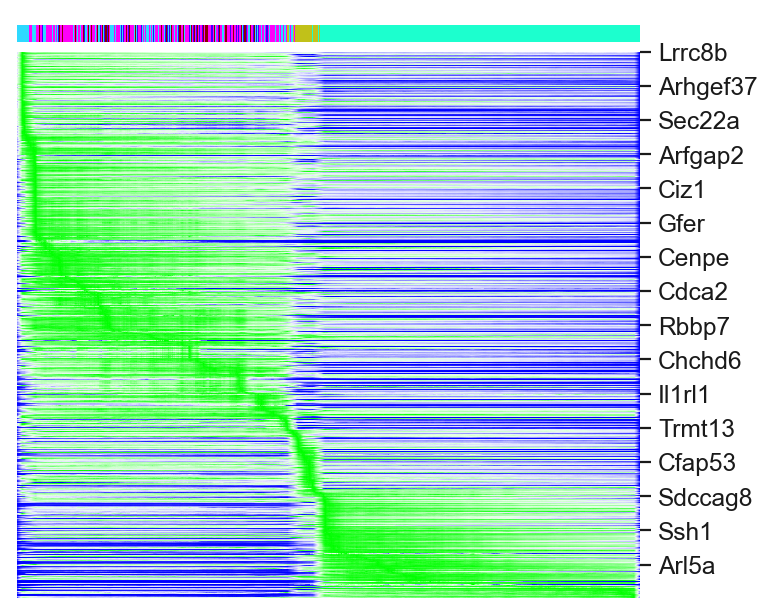

In [23]:
scv.pl.heatmap(adata_d0_emt_magic, var_names=emt_genes_common, sortby='cdh1_time', color_map=user_defined_cmap_degs, col_color='cell_type_subset',  figsize=(5,4), n_convolve=100)

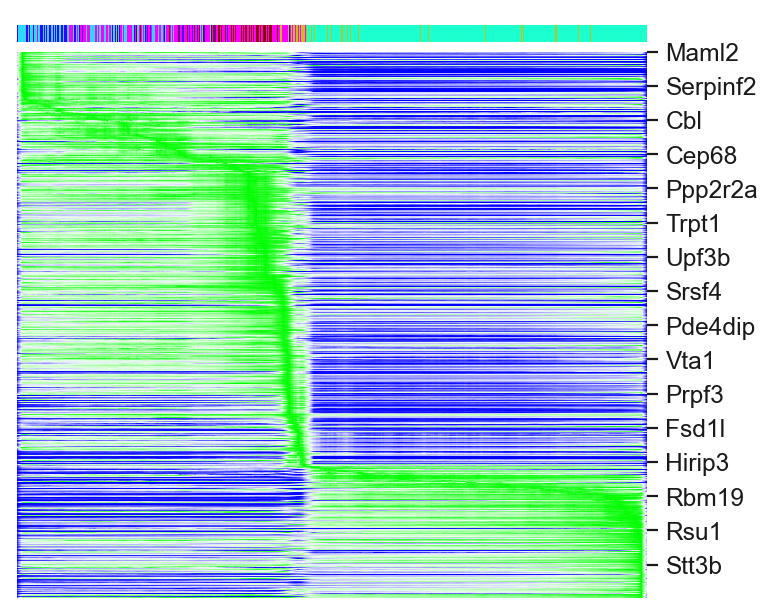

In [24]:
scv.pl.heatmap(adata_d0_emt_magic, var_names=emt_genes_common, sortby='vim_time', color_map=user_defined_cmap_degs, col_color='cell_type_subset',  figsize=(5,4), n_convolve=100)

### For the scatterplots

In [25]:
emt_genes = ['Pax4', 'Egr1', 'Eya1', 'Six1', 'Pax9', 'Pax1', 'Bmp6',  'Notch3', 'Rhoj', 'Tm4sf1',  'Sdc4',  'Trpm3', 
             'H2-Aa','Cdk19','Epcam', 'Cldn3', 'Plin2', 'Kif19a', 'Plet1',  'Cldn4',  'Ephb1', 'Pecam1', 'Pdgfra', 
             'Pdpn','Jun', 'Junb', 'Atf4', 'Sox4', 'Klf6', 'Cd44', 'Fn1', 'Tgm2', 'Foxc2', 'Prrx1', 'Pou5f1', 'Tcf4', 
             'Cdh1', 'Esrp1', 'Grhl2', 'Esrp2', 'Ovol1', 'Ovol2', 'Snai1', 'Rbfox2', 'Vim', 'Zeb2', 'Zeb1', 'Twist1',
             'Zeb2', 'Vim', 'Spp1', 'Krt14', 'Ar', 'Sparc', 'Esrp1', 	'Slc16a11',	'Slc9a3r1', 'Isl1',	'Cdk19',
             'Ptprd',	'Taldo1',	'BC006965', 'Aldoc',	'Socs2',	'Fam107a','Fbxo2', 'Nedd4l',	'Shank2',
             'Id2',	'Arl4c', 'Des',	'Slc5a8',	'Kcnk1',	'Kirrel3',		'Prxl2a', 'Thsd4',	'Rdh10',	'Rhov',
             'Cited4',	'Galm',	'Rtl4',	'Gna14',	'Dclk2',	'Nipal2', 'Gata6', 'Fap', 'Fn1', 'Gas1', 'Notch2',  
             'Pdgfrb', 'Ndrg2', 'Prrx1', 'Olfm2', 'Notch1', 'Il6',  'Snai2', 'Spp1', 'Tgfb1', 'Tgfbr3', 'Thy1', 
             'Timp1', 'Timp3']

In [26]:
adata_d0_emt_magic = magic_op.fit_transform(TEC_d0_emt, genes=emt_genes)

Calculating MAGIC...
  Running MAGIC on 5608 cells and 22895 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.13 seconds.
    Calculating affinities...
    Calculated affinities in 2.12 seconds.
  Calculated graph and diffusion operator in 7.43 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 7.65 seconds.


In [27]:
adata_d0_emt_magic.uns['cell_type_subset_colors'] = ['#1cffce', '#2ed9ff', '#c1c119', '#8b0000', '#3B00FB', '#fe00fa']

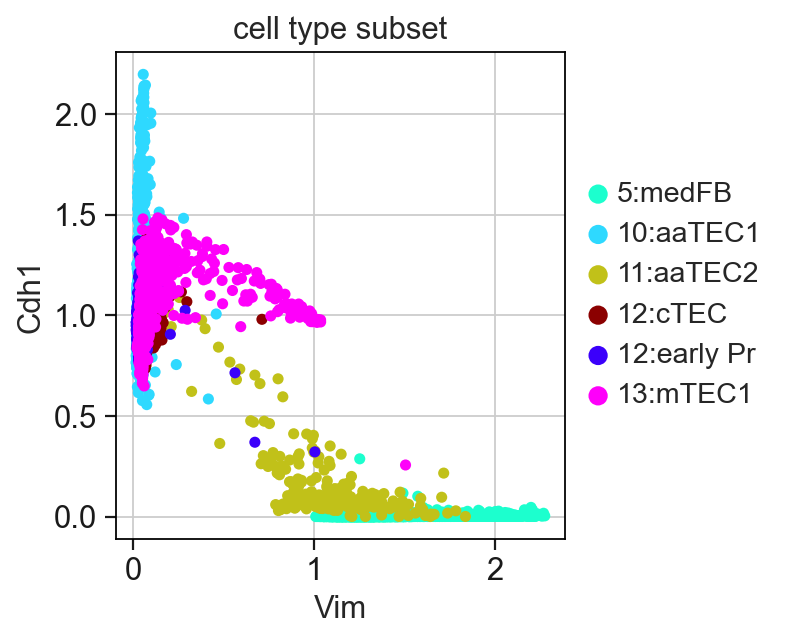

In [28]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)

sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='cell_type_subset', palette=adata_d0_emt_magic.uns['cell_type_subset_colors'], projection='2d', size=100,  color_map='inferno')

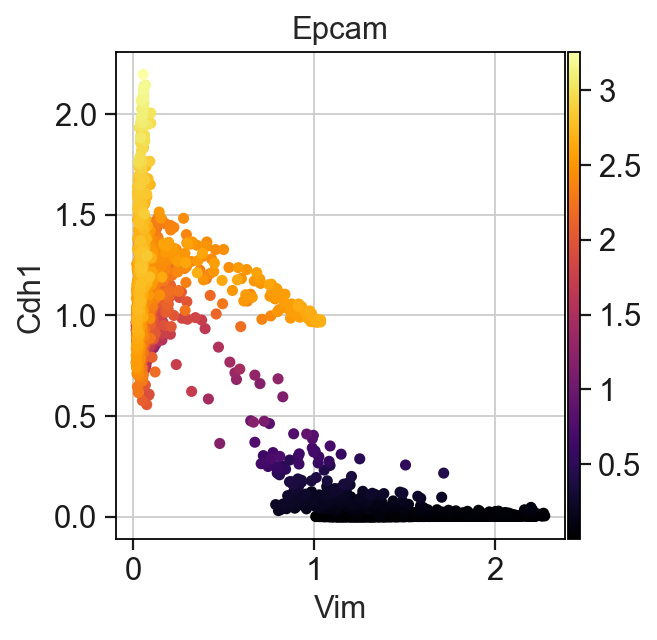

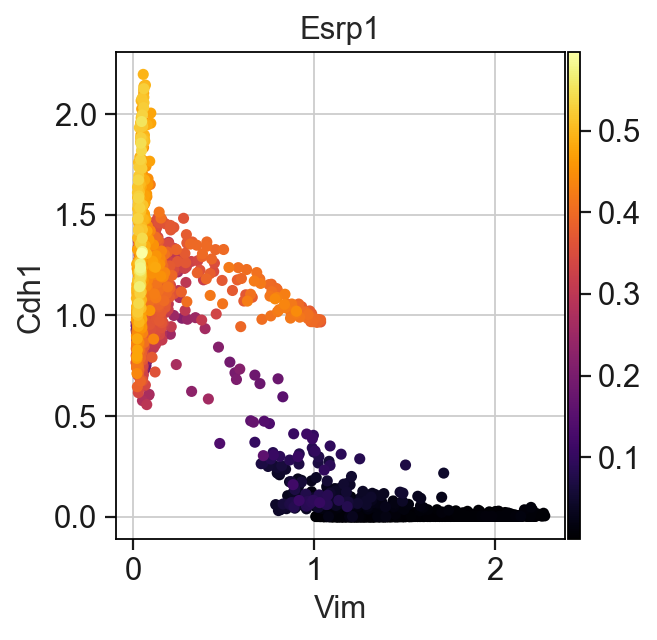

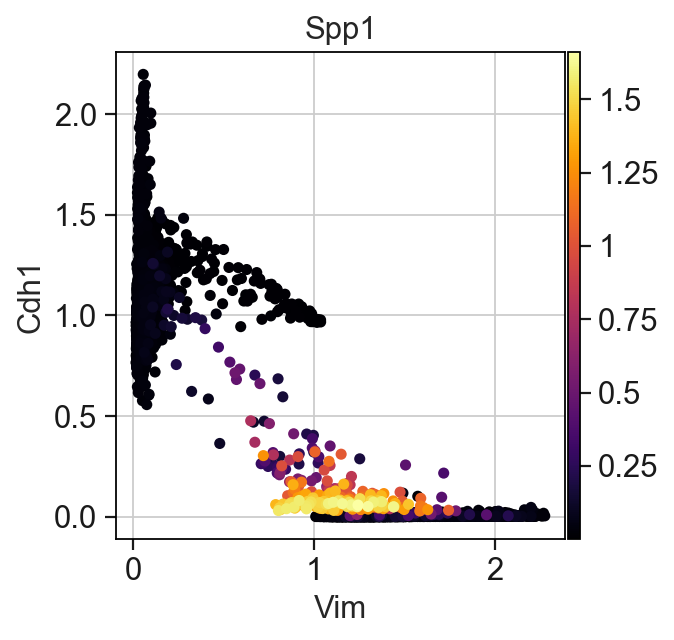

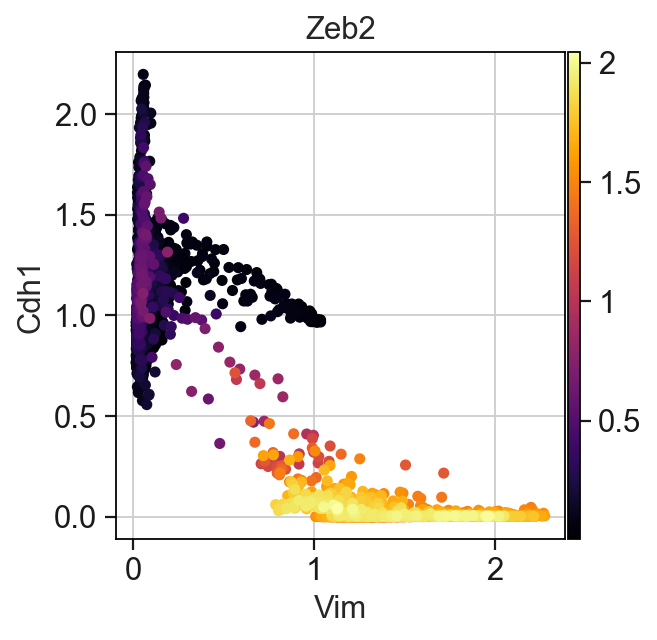

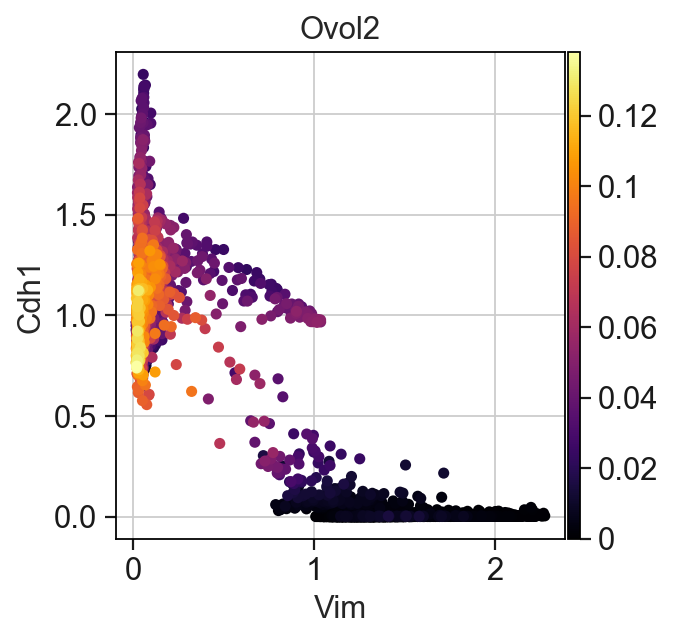

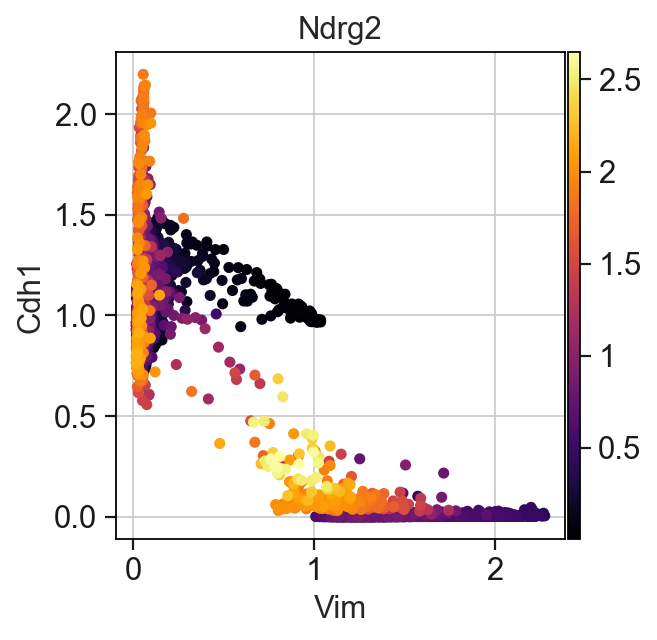

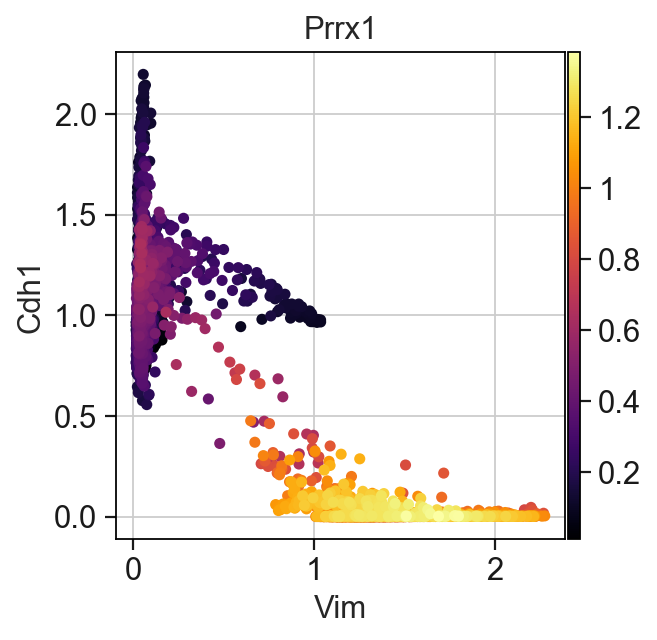

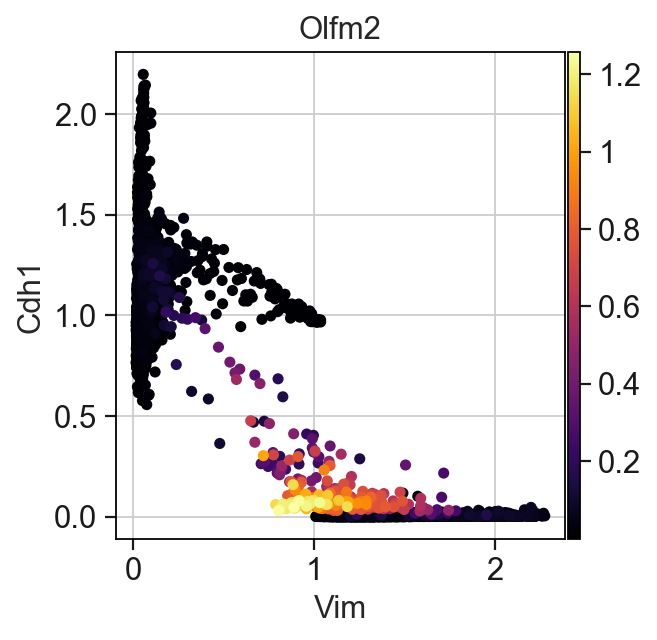

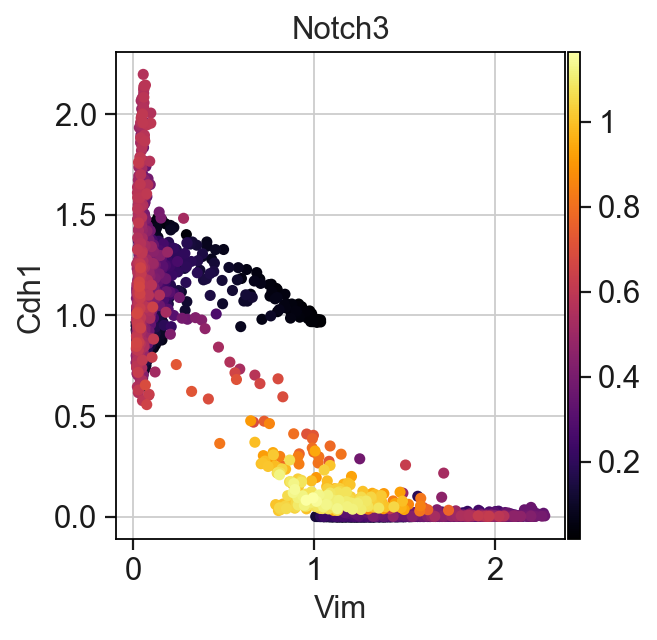

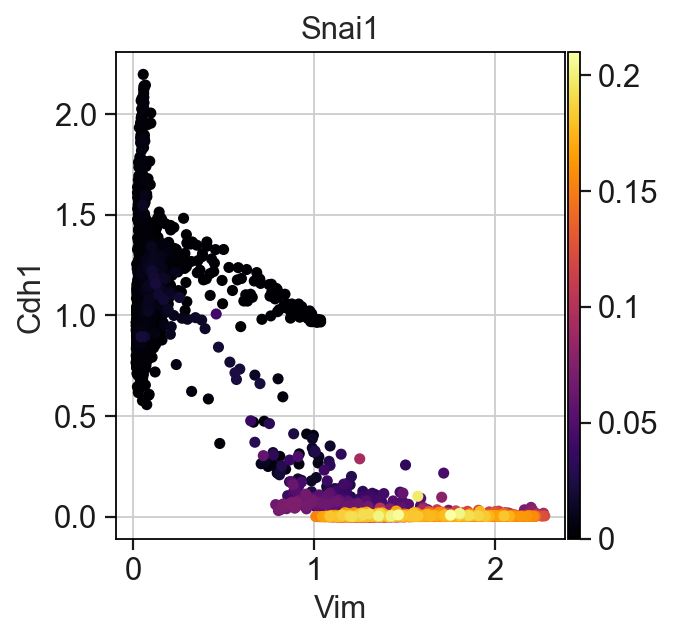

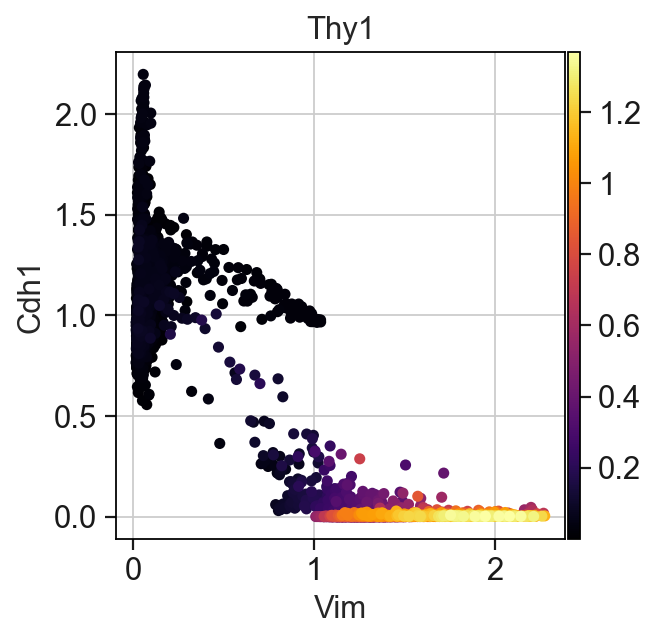

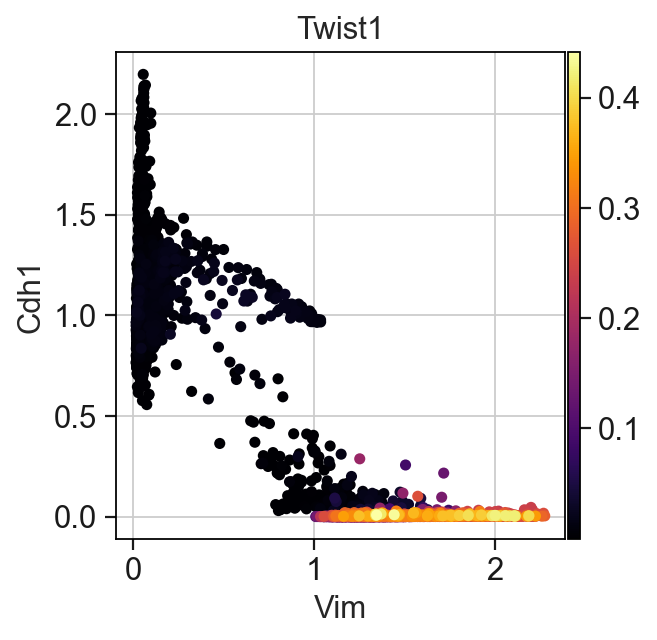

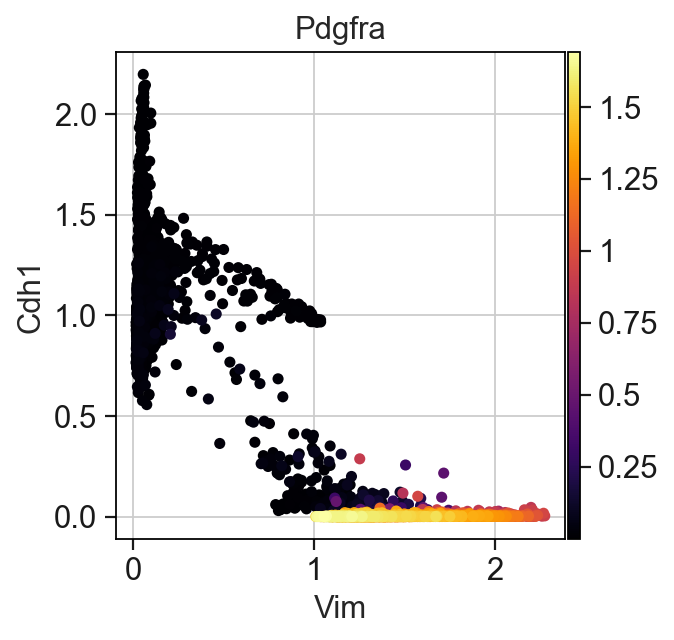

In [29]:
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Epcam', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Esrp1', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Spp1', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Zeb2', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Ovol2', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Ndrg2', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Prrx1', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Olfm2', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Notch3', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Snai1', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Thy1', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Twist1', projection='2d', size=100, color_map='inferno')
sc.pl.scatter(adata_d0_emt_magic, x='Vim',  y='Cdh1', color='Pdgfra', projection='2d', size=100, color_map='inferno')